In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy as sc
import numpy.random as rn
import networkx as nx
import my_networkx as my_nx

mpl.rcParams.update({'font.size': 18})


In [2]:
A = np.array([[0, 1, 0, 0, 0, 0],[1, 0, 1, 0, 1, 0],[0, 1, 0, 1, 0, 0],[0, 0, 1, 0, 1, 0],[0, 1, 0, 1, 0, 1],[0, 0, 0, 0, 1, 0]])
print(A)

[[0 1 0 0 0 0]
 [1 0 1 0 1 0]
 [0 1 0 1 0 0]
 [0 0 1 0 1 0]
 [0 1 0 1 0 1]
 [0 0 0 0 1 0]]


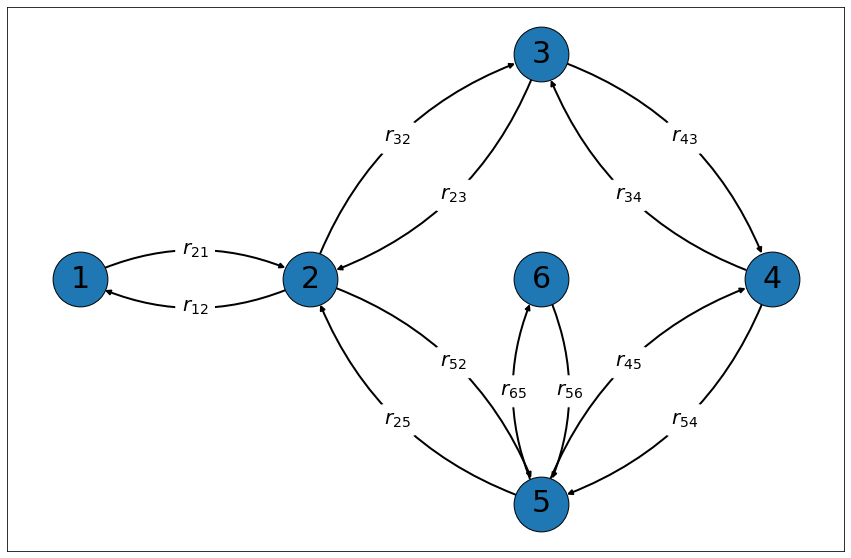

In [3]:
def plot_network(A, we=np.ones_like(A), position={1:(0,0),2:(1,0),3:(2,1),4:(3,0),5:(2,-1),6:(2,0)}, name="figures/Example_Calmodulin_1.pdf"):
    
    G = nx.DiGraph() 
    edges = []
    k = 0
    color = []
    for i in range(len(A[:,0])): 
        for j in range(len(A[:,0])): 
            if A[i, j] == 1: 
                #G.add_edge(i,j)
                edges.append((i+1, j+1, {"weight":we[i,j], "w":r"$r_{%d%d}$" % (i+1, j+1)}))
                color.append(we[i,j])

        G.add_node(i+1)

    G.add_edges_from(edges)

    weights = [ 4 * G[u][v]['weight'] for u,v in G.edges]

    fixed_positions = position #dict with two of the positions set
    fixed_nodes = fixed_positions.keys()
    pos = nx.spring_layout(G, pos=fixed_positions, fixed=fixed_nodes)

    cmap = plt.cm.plasma

    fig, ax = plt.subplots(figsize=(20, 10))
    nx.draw_networkx_nodes(G, pos, ax=ax, node_size=3000, edgecolors="k")
    nx.draw_networkx_labels(G, pos, ax=ax, font_size=30)

    curved_edges = [edge for edge in G.edges() if reversed(edge) in G.edges()]
    straight_edges = list(set(G.edges()) - set(curved_edges))
    nx.draw_networkx_edges(G, pos, ax=ax, edgelist=straight_edges, arrowstyle="<|-", width=5, node_size=3000)
    arc_rad = 0.2
    edges_plot = nx.draw_networkx_edges(G, pos, ax=ax, edgelist=curved_edges, connectionstyle=f'arc3, rad = {arc_rad}', arrowstyle="<|-", width=weights, edge_color=weights, arrowsize=20, node_size=3000)

    pc = mpl.collections.PatchCollection(edges_plot, cmap=cmap)
    pc.set_array(weights)

    edge_weights = nx.get_edge_attributes(G,'w')
    curved_edge_labels = {edge: edge_weights[edge] for edge in curved_edges}
    straight_edge_labels = {edge: edge_weights[edge] for edge in straight_edges}
    my_nx.my_draw_networkx_edge_labels(G, pos, ax=ax, edge_labels=curved_edge_labels,rotate=False,rad = arc_rad, font_size=20)
    nx.draw_networkx_edge_labels(G, pos, ax=ax, edge_labels=straight_edge_labels,rotate=False)
    plt.colorbar(pc, ax=ax)
    plt.savefig(name, dpi=500, bbox_inches="tight")

plot_network(A)

In [4]:
def printMatrix(s):
    
    for i in range(len(s)):
        for j in range(len(s[0])):
            print("%f   " % (s[i][j]), end="")
        print("\n") 

In [5]:
def Matrices(energies, A):
    N = len(energies)
    peq = np.exp(-energies)
    Z = np.sum(peq)
    peq = peq/Z
    # Probability matrix
    Pmatrix = np.zeros((N, N))
    for i in range(N):
        Pmatrix[i, i] = np.sqrt(peq[i])

    #Master operator DB
    L = np.zeros((N, N))

    for i in range(N):
        for j in range(N):
            if A[i, j] == 1:
                L[i, j] = np.exp((energies[j]-energies[i])/2)
        L[i, i] = - np.sum(L[i, :])
    # Symmetrised Master op DB
    Ls = np.matmul(np.linalg.inv(Pmatrix), np.matmul(L, Pmatrix))

    return Pmatrix, L, Ls, peq




In [6]:
energies = rn.exponential(1, size=(6))
print(energies)

[1.08043414 1.77675376 2.33751699 1.05233855 0.853644   0.91091134]


In [4]:
peq = np.exp(-energies)
Z = np.sum(peq)
peq = peq/Z

In [8]:
N = len(peq)
Pmatrix = np.zeros((N, N))
for i in range(N):
    Pmatrix[i, i] = np.sqrt(peq[i])

printMatrix(Pmatrix)

0.231963   0.000000   0.000000   0.000000   0.000000   0.000000   

0.000000   0.133469   0.000000   0.000000   0.000000   0.000000   

0.000000   0.000000   0.464729   0.000000   0.000000   0.000000   

0.000000   0.000000   0.000000   0.184809   0.000000   0.000000   

0.000000   0.000000   0.000000   0.000000   0.715879   0.000000   

0.000000   0.000000   0.000000   0.000000   0.000000   0.407148   



In [159]:
L = np.zeros((N, N))

for i in range(N):
    for j in range(N):
        if A[i, j] == 1:
            L[i, j] = np.exp(energies[j])
    L[i, i] = - np.sum(L[i, :])

Ls = np.matmul(np.linalg.inv(Pmatrix), np.matmul(L, Pmatrix))
print(Ls)


ew, ev = np.linalg.eigh(Ls)
print("\n eigenvalues")
print(ew)

D = np.matmul(ev.T, np.matmul(Ls, ev))
print(D)



symmetrised
[[-23.61475449   8.00203647   0.           0.           0.
    0.        ]
 [  8.00203647  -6.93019093   7.98516353   0.           5.98826628
    0.        ]
 [  0.           7.98516353 -25.08912227   1.9952394    0.
    0.        ]
 [  0.           0.           1.9952394   -4.21864092   1.49627804
    0.        ]
 [  0.           5.98826628   0.           1.49627804 -27.32041164
    1.84071832]
 [  0.           0.           0.           0.           1.84071832
   -1.5185139 ]]

 eigenvalues
[-3.20622929e+01 -2.66240199e+01 -2.43224025e+01 -4.18784225e+00
 -1.49507666e+00  7.83732545e-15]

 diagonalised
[[-3.20622929e+01 -1.79717352e-15 -5.57279917e-15  1.36240845e-15
   1.24206201e-15  6.75891572e-15]
 [ 1.80411242e-16 -2.66240199e+01  5.23019128e-15  3.49113100e-17
   2.37310172e-15  4.00232858e-16]
 [-5.86856952e-15  5.20243570e-15 -2.43224025e+01  9.72800399e-16
  -1.34094125e-15 -3.88743456e-15]
 [ 2.04090217e-15 -5.11743425e-17  1.17462463e-15 -4.18784225e+00
  -1.878

In [154]:
scale = 0.05
As = scale*np.array([[1/scale, 0, 0, 0, 0, 0], [0, 1/scale, 1, 0, -1, 0], [0, -1, 1/scale, 1, 0, 0], [0, 0, -1, 1/scale, 1, 0], [0, 1, 0, -1, 1/scale, 0], [0, 0, 0, 0, 0, 1/scale]])
print(As)

[[ 1.    0.    0.    0.    0.    0.  ]
 [ 0.    1.    0.05  0.   -0.05  0.  ]
 [ 0.   -0.05  1.    0.05  0.    0.  ]
 [ 0.    0.   -0.05  1.    0.05  0.  ]
 [ 0.    0.05  0.   -0.05  1.    0.  ]
 [ 0.    0.    0.    0.    0.    1.  ]]


In [155]:
Ltot = -sqrtLs.dot(As.dot(sqrtLs))
print(Ltot)

[[-2.36147545e+01  7.97187536e+00  3.35811216e-01  2.33595700e-04
  -3.51613636e-01  1.85865592e-02]
 [ 8.03219759e+00 -6.93019093e+00  7.60627563e+00  5.02195466e-02
   6.42635114e+00 -1.86752923e-02]
 [-3.35811216e-01  8.36405144e+00 -2.50891223e+01  1.43316493e+00
  -4.60581658e-01 -2.55577400e-02]
 [-2.33595700e-04 -5.02195466e-02  2.55731388e+00 -4.21864092e+00
   9.07433385e-01  3.10920536e-02]
 [ 3.51613636e-01  5.55018141e+00  4.60581658e-01  2.08512269e+00
  -2.73204116e+01  1.89297113e+00]
 [-1.85865592e-02  1.86752923e-02  2.55577400e-02 -3.10920536e-02
   1.78846551e+00 -1.51851390e+00]]


In [158]:
wow = np.matmul(Pmatrix, np.matmul(Ltot, np.linalg.inv(Pmatrix)))

for i in range(6):
    for j in range(6):
        if i != j and wow[i, j] < 0:
            wow[i, j] = 0
    #print(wow[i, :])
    print(np.sum(wow[i:]))

print(wow)

0.2631275178142547
0.005740540582803266
0.7051552159043624
0.20130078997518264
-4.9171372529244195e-08
0.045763454501535517
[[-2.36147545e+01  2.35257462e+01  3.35103131e-01  1.72249889e-04
   0.00000000e+00  1.68604103e-02]
 [ 2.72177033e+00 -6.93019093e+00  2.57200873e+00  1.25482738e-02
   1.62960415e+00  0.00000000e+00]
 [ 0.00000000e+00  2.47352506e+01 -2.50891223e+01  1.05902690e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  3.46077382e+00 -4.21864092e+00
   9.20918555e-01  3.82493835e-02]
 [ 4.69856385e-01  2.18871649e+01  6.14171062e-01  2.05458988e+00
  -2.73204116e+01  2.29462939e+00]
 [ 0.00000000e+00  6.07548812e-02  2.81149035e-02  0.00000000e+00
   1.47540757e+00 -1.51851390e+00]]


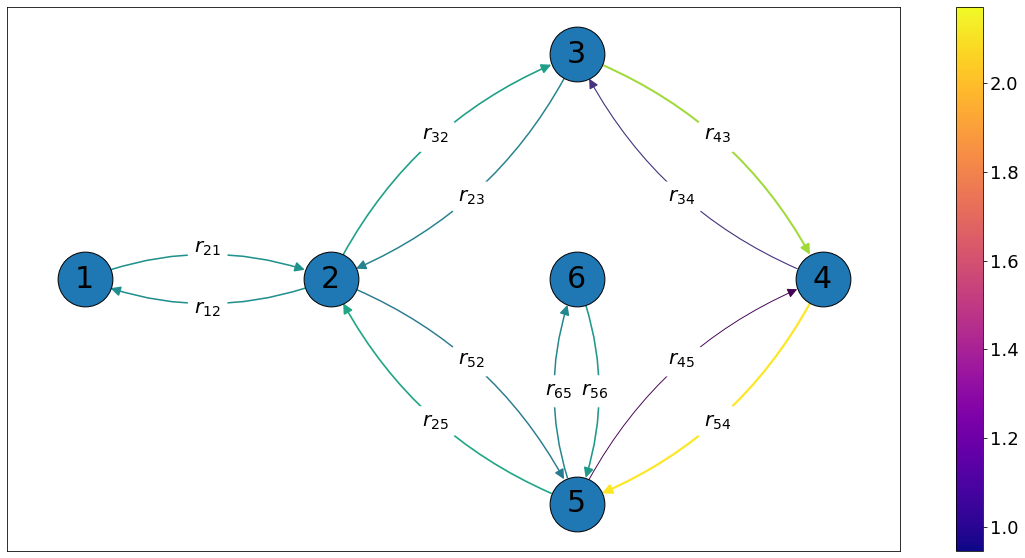

In [157]:
wow2 = np.matmul(wow, np.matmul(Pmatrix, Pmatrix))

plot_network(A, wow2, name="figures/Example_Calmodulin_2.pdf")

## Three State System

In [59]:
energies = rn.exponential(1, size=(3))
A = np.array([[0, 1, 1], [1, 0, 1], [1, 1, 0]])

def Matrices(energies, A):
    N = len(energies)
    peq = np.exp(-energies)
    Z = np.sum(peq)
    peq = peq/Z
    # Probability matrix
    Pmatrix = np.zeros((N, N))
    for i in range(N):
        Pmatrix[i, i] = np.sqrt(peq[i])

    #Master operator DB
    L = np.zeros((N, N))

    for i in range(N):
        for j in range(N):
            if A[i, j] == 1:
                L[i, j] = np.exp((energies[j]-energies[i])/2)
    for i in range(N):
        L[i, i] = - np.sum(L[:, i])
    # Symmetrised Master op DB
    Ls = np.matmul(np.linalg.inv(Pmatrix), np.matmul(L, Pmatrix))

    return Pmatrix, L, Ls, peq



Peq, L, Ls, peq = Matrices(energies=energies, A=A)


a = L[0, 1]
b = L[0, 2]
c = L[1, 0]
d = L[1, 2]
e = L[2, 0]
f = L[2, 1]



EWs, EVs = np.linalg.eigh(Ls)

print(np.linalg.eigh(Ls)[0])
print(np.linalg.eig(L)[0])

print(np.linalg.eig(L)[1])


printMatrix(Ls)
printMatrix(L)

print(peq)


E = np.linalg.eig(L)[0]

x = np.argmin(np.abs(E))


v = np.linalg.eig(L)[1]
v = v[:, x]
print(v, x)
print(v / peq)

[-3.12584934e+00 -2.90125497e+00  1.22731686e-16]
[ 0.         -2.90125497 -3.12584934]
[[ 0.66176907  0.80537022 -0.135284  ]
 [ 0.5498138  -0.5190213  -0.62969126]
 [ 0.50967292 -0.28634892  0.76497526]]
-1.789087   1.000000   1.000000   

1.000000   -2.059902   1.000000   

1.000000   1.000000   -2.178115   

-1.789087   1.097098   1.139482   

0.911496   -2.059902   1.038633   

0.877592   0.962804   -2.178115   

[0.38446876 0.31942597 0.29610527]
[0.66176907 0.5498138  0.50967292] 0
[1.72125579 1.72125579 1.72125579]


In [60]:
D = np.diag(EWs)


printMatrix(D)

Ds = np.matmul(EVs.T, np.matmul(Ls, EVs))

printMatrix(Ds)


print(Ds)

-3.125849   0.000000   0.000000   

0.000000   -2.901255   0.000000   

0.000000   0.000000   0.000000   

-3.125849   -0.000000   -0.000000   

-0.000000   -2.901255   0.000000   

-0.000000   0.000000   0.000000   

[[-3.12584934e+00 -1.29389350e-16 -3.74444964e-16]
 [-1.31539022e-16 -2.90125497e+00  2.83432489e-16]
 [-9.11964809e-17  2.35930450e-16  1.02388084e-16]]


In [61]:
print(EWs, -EWs)
sqrtLs = np.matmul(EVs, np.matmul(np.diag(np.sqrt(np.abs(EWs))), EVs.T)) 
printMatrix(sqrtLs)

[-3.12584934e+00 -2.90125497e+00  1.22731686e-16] [ 3.12584934e+00  2.90125497e+00 -1.22731686e-16]
1.049382   -0.592093   -0.580785   

-0.592093   1.183823   -0.554879   

-0.580785   -0.554879   1.238109   



In [62]:
scale = 0.1
A = scale * np.array([[0, 1, 0], [-1, 0, 0], [0, 0, 0]])


printMatrix(-np.matmul(sqrtLs, np.matmul(A, sqrtLs)))

-0.000000   -0.089171   0.092616   

0.089171   -0.000000   -0.101609   

-0.092616   0.101609   -0.000000   



In [63]:
printMatrix(-np.matmul(sqrtLs, np.matmul(np.identity(3) + A, sqrtLs)))

print(np.identity(3))

-1.789087   0.910829   1.092616   

1.089171   -2.059902   0.898391   

0.907384   1.101609   -2.178115   

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [64]:
positions = {1:(1, 0), 2:()}

In [65]:
Lneq = -np.matmul(sqrtLs, np.matmul(np.identity(3) + A, sqrtLs))#
printMatrix(Lneq)

-1.789087   0.910829   1.092616   

1.089171   -2.059902   0.898391   

0.907384   1.101609   -2.178115   



In [66]:
print(np.linalg.eig(Lneq)[0])
print(np.linalg.eig(Lneq)[1])
print(Peq)

[-1.78940629e-16+0.j         -3.01355216e+00+0.11934317j
 -3.01355216e+00-0.11934317j]
[[-0.62005545+0.j         -0.53885146-0.28556566j -0.53885146+0.28556566j]
 [-0.56517782+0.j         -0.10270755+0.31329351j -0.10270755-0.31329351j]
 [-0.54415556+0.j          0.72068696+0.j          0.72068696-0.j        ]]
[[0.62005545 0.         0.        ]
 [0.         0.56517782 0.        ]
 [0.         0.         0.54415556]]


In [67]:
print(np.matmul(Lneq, np.array([0.53117816, 0.53012983, 0.66091764])))
print(peq)
print(np.matmul(Lneq, peq))

[ 0.25466259  0.08029093 -0.37357623]
[0.38446876 0.31942597 0.29610527]
[-0.07337643  0.02678436  0.055792  ]


In [68]:
Lneqneq = np.matmul(Peq, np.matmul(Lneq, np.linalg.inv(Peq)))

printMatrix(Lneqneq)
print("##################")

c, c1 = np.linalg.eig(Lneqneq)
c2, c3 = np.linalg.eig(L)


printMatrix(c1)

print(c)

printMatrix(c3)

print(c2)

-1.789087   0.999269   1.245016   

0.992774   -2.059902   0.933099   

0.796313   1.060633   -2.178115   

##################
-0.661769   -0.580304   -0.580304   

-0.549814   -0.100819   -0.100819   

-0.509673   0.681123   0.681123   

[ 1.82954087e-16+0.j         -3.01355216e+00+0.11934317j
 -3.01355216e+00-0.11934317j]
0.661769   0.805370   -0.135284   

0.549814   -0.519021   -0.629691   

0.509673   -0.286349   0.764975   

[ 0.         -2.90125497 -3.12584934]


/home/vetkje/home/vetkje/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  """
